In [1]:
!pip3 install catboost

     |████████████████████████████████| 66.3MB 57kB/s 


In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
from lightgbm import LGBMClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from catboost import CatBoostClassifier

In [3]:
train = pd.read_csv('/content/drive/MyDrive/train_age_dataset.csv')
test = pd.read_csv('/content/drive/MyDrive/test_age_dataset.csv')

In [4]:
def make_transforms(train,test):
    NEW_CLASS = 32
    labels = train['age_group']
    train.drop(['age_group'], axis = 1, inplace = True)
    fnames = [train,test]
    data = pd.concat(fnames)
    
    data['avgTimeSpent'] = np.log(data['avgTimeSpent'])
    data['avgTimeSpent'] = pd.qcut(data['avgTimeSpent'].rank(method='first'), NEW_CLASS, labels=False)
  
    data['avgDuration'] = np.log(data['avgDuration'])
    data['avgDuration'] = pd.qcut(data['avgDuration'].rank(method='first'), NEW_CLASS, labels=False)

    data['max_repetitive_punc'] = np.log(data['max_repetitive_punc']+1e-4)
    #data['max_repetitive_punc'] = pd.qcut(data['max_repetitive_punc'].rank(method='first'), NEW_CLASS, labels=False)
    
    data['response'] = data['creations'] + data['avgComments']
    data['response'] = np.log((data['avgComments'] + data['creations'])+1e-6)
    #data['response'] = pd.qcut(data['response'].rank(method='first'), NEW_CLASS, labels=False) 
        
    data['creations'] = np.log((data['creations']+1e-6))
    data['creations'] = pd.qcut(data['creations'].rank(method='first'), NEW_CLASS, labels=False)  
    
    data['total_char_used'] =data['punctuations_per_action'] +  data['num_of_hashtags_per_action'] +  data['emoji_count_per_action'] + data['number_of_words_per_action']
    data['total_char_used'] = pd.qcut(data['total_char_used'].rank(method='first'), 4, labels=False)

    data['new']= np.log(data['following_rate'] + data['followers_avg_age']+data['following_avg_age'] + data['num_of_comments'] + 1e-4)
    data['new'] = pd.qcut(data['new'].rank(method='first'), NEW_CLASS, labels=False)

    data['content_views'] = np.log(data['content_views'] + 1e-3)
    data['content_views'] = pd.qcut(data['content_views'].rank(method='first'),NEW_CLASS,labels=False)

    data['weekends_trails_watched_per_day'] = np.log(data['weekends_trails_watched_per_day'] + 1e-3)
    data['weekends_trails_watched_per_day'] = pd.qcut(data['weekends_trails_watched_per_day'].rank(method='first'), NEW_CLASS, labels=False)
    
    data['weekdays_trails_watched_per_day'] = np.log(data['weekdays_trails_watched_per_day'] + 1e-3)
    data['weekends_trails_watched_per_day'] = pd.qcut(data['weekends_trails_watched_per_day'].rank(method='first'), NEW_CLASS, labels=False)
   
    data['avgt2'] = np.log(train['avgt2'] + 1e-3)
    data['avgt2'] = pd.qcut(data['avgt2'].rank(method='first'), NEW_CLASS, labels=False)

    data['total_activity_per_day'] = data['slot4_trails_watched_per_day'] + data['slot3_trails_watched_per_day'] + data['slot2_trails_watched_per_day'] + data['slot1_trails_watched_per_day'] +data['content_views']
    data['total_activity_per_day'] = np.log(data['total_activity_per_day'])
    data['total_activity_per_day'] = pd.qcut(data['total_activity_per_day'].rank(method='first'), NEW_CLASS, labels=False)
    
    
    data['slot4_trails_watched_per_day'] = np.log(data['slot4_trails_watched_per_day']+ 1e-2)
    data['slot3_trails_watched_per_day'] = np.log(data['slot3_trails_watched_per_day']+ 1e-2)
    data['slot2_trails_watched_per_day'] = np.log(data['slot2_trails_watched_per_day']+ 1e-2)
    data['slot1_trails_watched_per_day'] = np.log(data['slot1_trails_watched_per_day']+ 1e-2)
    
    
    data['slot4_trails_watched_per_day'] = pd.qcut(data['slot4_trails_watched_per_day'].rank(method='first'), NEW_CLASS, labels=False)
    data['slot3_trails_watched_per_day'] = pd.qcut(data['slot3_trails_watched_per_day'].rank(method='first'), NEW_CLASS, labels=False)
    data['slot2_trails_watched_per_day'] = pd.qcut(data['slot2_trails_watched_per_day'].rank(method='first'), NEW_CLASS, labels=False)
    data['slot1_trails_watched_per_day'] = pd.qcut(data['slot1_trails_watched_per_day'].rank(method='first'), NEW_CLASS, labels=False)

    data['avgComments'] = np.log(data['avgComments'] + 1e-3)
    data['avgComments'] = pd.qcut(data['avgComments'].rank(method='first'),NEW_CLASS,labels=False)

    data['sundaram'] = data['avgCompletion'] + data['avgDuration']
    data['sundaram'] = np.log(data['sundaram'] + 1e-3)
    data['sundaram'] = pd.qcut(data['sundaram'].rank(method='first'),NEW_CLASS,labels=False)
    
    data['avgCompletion']=np.log(data['avgCompletion']+ 1e-3)
    data['avgCompletion']= pd.qcut(data['avgCompletion'].rank(method='first'),NEW_CLASS,labels=False)

    data.drop(['num_of_hashtags_per_action','emoji_count_per_action','number_of_words_per_action','punctuations_per_action'],axis = 1 ,inplace = True)
    data.drop(['following_rate','followers_avg_age','following_avg_age','num_of_comments'],axis = 1 ,inplace = True)
    #seprating Train and test data again
    train_data = data[:train.shape[0]]
    test_data = data[train.shape[0]:]
    train_data['age_group'] = labels
    return train_data,test_data

In [5]:
train_data, test_data = make_transforms(train,test)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


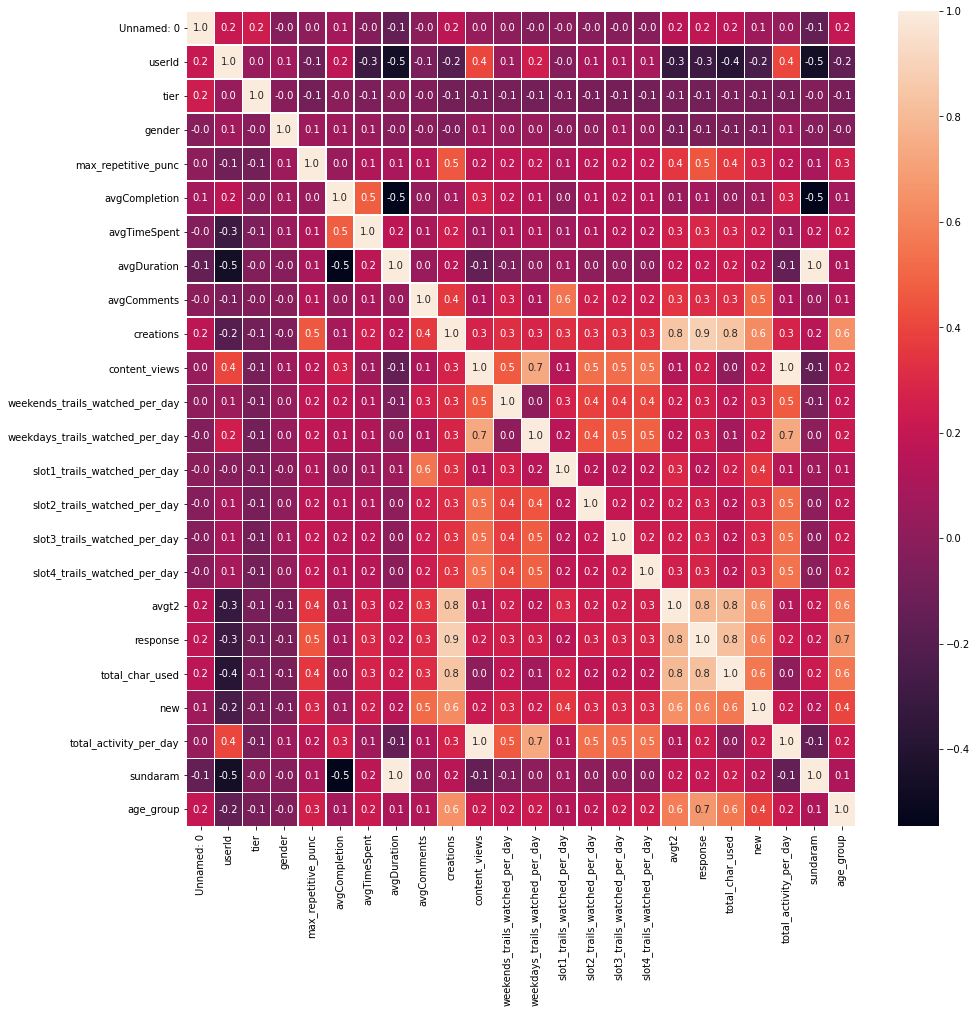

In [6]:
f,ax = plt.subplots(figsize=(15, 15))
sns.heatmap(train_data.corr(), annot=True, linewidths=.5, fmt= '.1f',ax=ax)
plt.show()

In [7]:
train = train_data[:485000]
val = train_data[485000:]

X_train = train.drop(['age_group'], axis = 1)
Y_train = train['age_group']

X_val = val.drop(['age_group'], axis = 1)
Y_val = val['age_group']

In [8]:
cbc = CatBoostClassifier(iterations = 1000, depth=5, learning_rate=0.2, task_type='CPU',verbose = 100)

xgbc = XGBClassifier(learning_rate=0.2,
                     max_depth=7,
                     n_estimators=500,
                     verbosity=1)
rfc = RandomForestClassifier(n_estimators=1000, n_jobs=-1, random_state=10, max_features=0.8, bootstrap=True, verbose = 1)
knn = KNeighborsClassifier(n_neighbors=4)
#lgbmc = LGBMClassifier(random_state=10,n_estimators=500, colsample_bytree=0.7, 
                       #max_depth=7, learning_rate=0.2,num_leaves=2^(9),boosting_type='gbdt')

In [9]:
ensemble = VotingClassifier(estimators=[('knn',knn),('xgbc', xgbc),('cbc',cbc),('rfc', rfc)], voting='soft')
ensemble.fit(X_train,Y_train)

0:	learn: 1.0908559	total: 530ms	remaining: 8m 49s
100:	learn: 0.4872072	total: 37.7s	remaining: 5m 35s
200:	learn: 0.4769584	total: 1m 13s	remaining: 4m 53s
300:	learn: 0.4716738	total: 1m 49s	remaining: 4m 13s
400:	learn: 0.4677832	total: 2m 24s	remaining: 3m 35s
500:	learn: 0.4641579	total: 2m 59s	remaining: 2m 59s
600:	learn: 0.4614282	total: 3m 34s	remaining: 2m 22s
700:	learn: 0.4588393	total: 4m 9s	remaining: 1m 46s
800:	learn: 0.4565485	total: 4m 44s	remaining: 1m 10s
900:	learn: 0.4543746	total: 5m 19s	remaining: 35.1s
999:	learn: 0.4522265	total: 5m 54s	remaining: 0us


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed: 11.0min
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed: 25.2min
[Parallel(n_jobs=-1)]: Done 796 tasks      | elapsed: 46.0min
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed: 58.0min finished


VotingClassifier(estimators=[('knn',
                              KNeighborsClassifier(algorithm='auto',
                                                   leaf_size=30,
                                                   metric='minkowski',
                                                   metric_params=None,
                                                   n_jobs=None, n_neighbors=4,
                                                   p=2, weights='uniform')),
                             ('xgbc',
                              XGBClassifier(base_score=0.5, booster='gbtree',
                                            colsample_bylevel=1,
                                            colsample_bynode=1,
                                            colsample_bytree=1, gamma=0,
                                            learning_rate=0.2, max_delta_step=0,
                                            max_depth=7, min_chil...
                                                     criterion=

In [10]:
Y_pred = ensemble.predict(X_val)
accuracy = accuracy_score(Y_pred,Y_val)

[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.5s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.8s
[Parallel(n_jobs=2)]: Done 446 tasks      | elapsed:    1.1s
[Parallel(n_jobs=2)]: Done 796 tasks      | elapsed:    1.5s
[Parallel(n_jobs=2)]: Done 1000 out of 1000 | elapsed:    1.8s finished


In [11]:
print(accuracy)

0.8274438999226206


In [12]:
prediction = ensemble.predict(test_data)

[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.6s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    2.3s
[Parallel(n_jobs=2)]: Done 446 tasks      | elapsed:    5.1s
[Parallel(n_jobs=2)]: Done 796 tasks      | elapsed:    8.7s
[Parallel(n_jobs=2)]: Done 1000 out of 1000 | elapsed:   10.8s finished


In [13]:
DF = pd.DataFrame(prediction) 

In [14]:
DF.rename(columns = {0:'prediction'}, inplace = True)

In [15]:
DF.to_csv('prediction.csv', index = False) 